# Linear Regression Algorithm using Bitcoin daily data from yfinance from 9-10-2014 - 9-10-2023


### Get the Data and Import Libraries


In [83]:
#imports
import pandas as pd
import numpy as np
from pathlib import Path
import hvplot.pandas
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn import metrics
from sklearn.metrics import mean_absolute_error

In [59]:
# Import the BTC-AUD dataset into a Pandas Dataframe
btc_df = pd.read_csv(
    Path("./BTC-AUD.csv"), 
    index_col='Date', 
    infer_datetime_format=True, 
    parse_dates=True
)

In [60]:
# Review the DataFrame
btc_df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-10-09,399.171661,435.658539,391.848328,416.601227,416.601227,95458918
2014-10-10,416.214355,427.426758,405.331879,416.306274,416.306274,50277145
2014-10-11,416.075989,422.787567,409.845703,417.154877,417.154877,15365803
2014-10-12,417.508331,437.739990,410.067963,436.267151,436.267151,20229111
2014-10-13,435.543365,453.506134,422.562439,446.136444,446.136444,40248429
...,...,...,...,...,...,...
2023-10-05,43478.867188,43997.480469,43171.464844,43926.378906,43926.378906,17607838598
2023-10-06,43925.199219,44230.550781,43056.265625,43045.859375,43045.859375,18648535373
2023-10-07,43039.910156,44255.226563,43024.632813,43775.996094,43775.996094,21134698079


### Get Insights of the Data

In [61]:
btc_df.hvplot.line(x="Date", y="Close")

:Curve   [Date]   (Close)

In [62]:
btc_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3288 entries, 2014-10-09 to 2023-10-09
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3288 non-null   float64
 1   High       3288 non-null   float64
 2   Low        3288 non-null   float64
 3   Close      3288 non-null   float64
 4   Adj Close  3288 non-null   float64
 5   Volume     3288 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 179.8 KB


In [63]:
btc_df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,3288.000000,3288.000000,3288.000000,3288.000000,3288.000000,3.288000e+03
mean,19641.320293,20085.172584,19158.403958,19652.053609,19652.053609,2.331877e+10
std,21812.565291,22313.856971,21245.802999,21809.290611,21809.290611,2.657865e+10
min,217.344894,257.455017,210.286896,218.826630,218.826630,6.757192e+06
25%,1218.808930,1224.354431,1190.458374,1218.746216,1218.746216,2.068370e+08
50%,11345.301269,11656.556640,11006.660157,11353.556640,11353.556640,1.587150e+10
75%,32244.785156,32841.286133,31647.302735,32246.588379,32246.588379,3.849653e+10
max,91103.179688,93136.890625,90001.531250,91126.234375,91126.234375,4.554690e+11


## Create RSI Indicator

In [64]:
# Calculate RSI
def calculate_rsi(data, period):
    price_diff = data['Close'].diff()
    gain = price_diff.where(price_diff > 0, 0)
    loss = -price_diff.where(price_diff < 0, 0)
    
    avg_gain = gain.rolling(window=period).mean()
    avg_loss = loss.rolling(window=period).mean()
    
    relative_strength = avg_gain / avg_loss
    rsi = 100 - (100 / (1 + relative_strength))
    
    return rsi

In [65]:
# Add RSI to the DataFrame
btc_df['RSI'] = calculate_rsi(btc_df, period=14)

## Create daily returns and signal for +/- daily returns

In [66]:
# Add Daily Returns
# Use the pct_change function to generate returns from close prices
btc_df["Actual Returns"] = btc_df["Close"].pct_change()

# Initialize the new Signal column
btc_df['Signal'] = 0.0

# When Actual Returns are greater than or equal to 0, generate signal to buy stock long
btc_df.loc[(btc_df['Actual Returns'] >= 0), 'Signal'] = 1

# When Actual Returns are less than 0, generate signal to sell stock short
btc_df.loc[(btc_df['Actual Returns'] < 0), 'Signal'] = -1

# Review the DataFrame
display(btc_df.head())
display(btc_df.tail())

,Open,High,Low,Close,Adj Close,Volume,RSI,Actual Returns,Signal
Date,,,,,,,,,
2014-10-09,399.171661,435.658539,391.848328,416.601227,416.601227,95458918,NaN,NaN,0.0
2014-10-10,416.214355,427.426758,405.331879,416.306274,416.306274,50277145,NaN,-0.000708,-1.0
2014-10-11,416.075989,422.787567,409.845703,417.154877,417.154877,15365803,NaN,0.002038,1.0
2014-10-12,417.508331,437.739990,410.067963,436.267151,436.267151,20229111,NaN,0.045816,1.0
2014-10-13,435.543365,453.506134,422.562439,446.136444,446.136444,40248429,NaN,0.022622,1.0


,Open,High,Low,Close,Adj Close,Volume,RSI,Actual Returns,Signal
Date,,,,,,,,,
2023-10-05,43478.867188,43997.480469,43171.464844,43926.378906,43926.378906,17607838598,66.701126,0.010259,1.0
2023-10-06,43925.199219,44230.550781,43056.265625,43045.859375,43045.859375,18648535373,64.561913,-0.020045,-1.0
2023-10-07,43039.910156,44255.226563,43024.632813,43775.996094,43775.996094,21134698079,70.929287,0.016962,1.0
2023-10-08,43776.285156,43903.652344,43656.675781,43810.835938,43810.835938,10264793466,71.100067,0.000796,1.0
2023-10-09,43851.117188,43931.265625,43662.226563,43768.171875,43768.171875,11954185216,76.827857,-0.000974,-1.0


In [67]:
# shift RSI down as that is going to be used as X feature and the previous days RSI causes the following days close. 
btc_df['RSI_shifted'] = btc_df['RSI'].shift()
# Drop all NaN values from the DataFrame
btc_df = btc_df.dropna()
btc_df

,Open,High,Low,Close,Adj Close,Volume,RSI,Actual Returns,Signal,RSI_shifted
Date,,,,,,,,,,
2014-10-23,436.872009,439.904053,406.995880,409.525818,409.525818,30229548,47.226533,-0.063075,-1.0,60.248656
2014-10-24,409.724640,413.323883,402.994171,407.488068,407.488068,17723107,46.589971,-0.004976,-1.0,47.226533
2014-10-25,407.790527,409.211945,389.898804,394.895386,394.895386,20613486,42.108925,-0.030903,-1.0,46.589971
2014-10-26,395.140991,408.484192,391.097351,402.935364,402.935364,12805294,37.177114,0.020360,1.0,42.108925
2014-10-27,403.018311,407.258667,397.374756,400.941620,400.941620,14803498,31.491846,-0.004948,-1.0,37.177114
...,...,...,...,...,...,...,...,...,...,...
2023-10-05,43478.867188,43997.480469,43171.464844,43926.378906,43926.378906,17607838598,66.701126,0.010259,1.0,64.106008
2023-10-06,43925.199219,44230.550781,43056.265625,43045.859375,43045.859375,18648535373,64.561913,-0.020045,-1.0,66.701126
2023-10-07,43039.910156,44255.226563,43024.632813,43775.996094,43775.996094,21134698079,70.929287,0.016962,1.0,64.561913


## Create LR Model

In [68]:
# Use the RSI signal as the feature (X) and price change as the target variable (y)
X = btc_df['RSI_shifted'].values 
y = btc_df['Close'].pct_change().dropna().values
X

array([60.24865629, 47.22653336, 46.58997146, ..., 64.56191287,
       70.92928652, 71.10006681])

In [69]:
y

array([-0.00497588, -0.03090319,  0.02035977, ...,  0.01696183,
        0.00079587, -0.00097382])

In [70]:
# Ensure that X and y have the same number of samples
X = X[1:] # Remove the last row of X to match the lengths of X and y to solve the imbalance error from the initial run
X

array([47.22653336, 46.58997146, 42.10892548, ..., 64.56191287,
       70.92928652, 71.10006681])

In [71]:
# Split the data into training and testing sets...
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [72]:
# Initialize the linear regression model
model = LinearRegression()

In [74]:
# Fit the model on the training data
model.fit(X_train.reshape(-1, 1), y_train)

LinearRegression()

In [76]:
# Make predictions on the test data
y_pred = model.predict(X_test.reshape(-1, 1))

In [77]:
# Review the model's predicted values
results = pd.DataFrame({
    "Prediction": y_pred, 
    "Actual": y_test
}).reset_index(drop=True)
results

,Prediction,Actual
0,0.004801,-0.014537
1,0.001414,0.009415
2,0.001842,0.002963
3,-0.001068,0.071739
4,0.001397,-0.011910
...,...,...
650,0.005014,0.106879
651,0.001398,0.004259
652,0.002669,0.051604
653,0.000655,-0.006971


### Calculate Performance Metrics

In [87]:
# Calculate MAE
mae = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error (MAE):", mae)

# Calculate MSE
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error (MSE):", mse)

# Calculate R2 score
r2 = r2_score(y_test, y_pred)
print("R-squared (R2) Score:", r2)


Mean Absolute Error (MAE): 0.022095519896889484
Mean Squared Error (MSE): 0.0010262891696110694
R-squared (R2) Score: 0.0038806212864442857


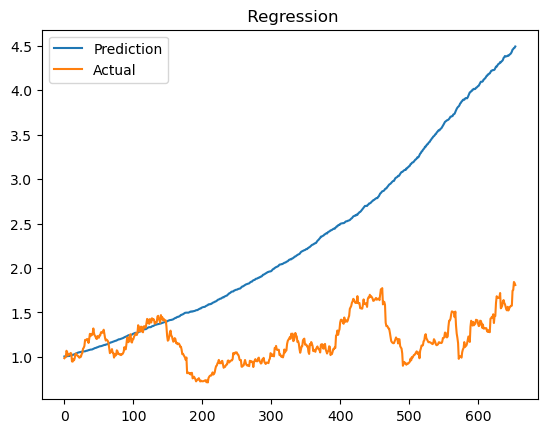

In [88]:
# Plot the actual returns versus the strategy returns
(1 + results[["Prediction", "Actual"]]).cumprod().plot(title=' Regression')
plt.savefig('Linear_regression_plot.png')